In [1]:
import warnings
from collections import defaultdict
from os.path import join as j
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial import distance
from scipy import stats
from scipy.special import kl_div
import seaborn as sns

In [2]:
with open("../data_dirs.txt", "r") as f: # your dataset folder should  be in a text file here
    DATA_DIRS = f.readlines()
    DATA_DIRS = [p.strip() for p in DATA_DIRS]

In [3]:
EMB_PROPERTY = ["undirected"]*3 + ["title"]*3 + ["abstract"]*3
EMB_METHOD = ["leigenmap", "node2vec", "residual2vec", "doc2vec", "scibert", "sentencebert", "doc2vec", "scibert", "sentencebert"]

In [4]:
rogs = {}

In [5]:
for PROPERTY, EMBEDDING_METHOD in zip(EMB_PROPERTY, EMB_METHOD):
    ROG_PATH = j(DATA_DIRS[0], "derived", "rog", "aps_all_2010_{}_{}_rog.csv".format(PROPERTY, EMBEDDING_METHOD))
    rogs[(PROPERTY, EMBEDDING_METHOD)] = pd.read_csv(ROG_PATH, index_col = "PACS_LEVEL")

In [6]:
? stats.kruskal

Signature:  stats.kruskal(*args, nan_policy='propagate')
Docstring:
Compute the Kruskal-Wallis H-test for independent samples.

The Kruskal-Wallis H-test tests the null hypothesis that the population
median of all of the groups are equal.  It is a non-parametric version of
ANOVA.  The test works on 2 or more independent samples, which may have
different sizes.  Note that rejecting the null hypothesis does not
indicate which of the groups differs.  Post hoc comparisons between
groups are required to determine which groups are different.

Parameters
----------
sample1, sample2, ... : array_like
   Two or more arrays with the sample measurements can be given as
   arguments.
nan_policy : {'propagate', 'raise', 'omit'}, optional
    Defines how to handle when input contains nan.
    The following options are available (default is 'propagate'):

      * 'propagate': returns nan
      * 'raise': throws an error
      * 'omit': performs the calculations ignoring nan values

Returns
-------
st

In [7]:
for pe, df in rogs.items():
    print(pe, stats.kruskal(df.loc[1].ROG, df.loc[2].ROG, df.loc[3].ROG, df.loc[5].ROG))

('undirected', 'leigenmap') KruskalResult(statistic=452.22197796587824, pvalue=1.0760148689045027e-97)
('undirected', 'node2vec') KruskalResult(statistic=319.9702427273278, pvalue=4.733587966221547e-69)
('undirected', 'residual2vec') KruskalResult(statistic=295.8538867806974, pvalue=7.853875753997185e-64)
('title', 'doc2vec') KruskalResult(statistic=170.1850294694772, pvalue=1.1607024833763085e-36)
('title', 'scibert') KruskalResult(statistic=82.2871919047169, pvalue=9.916405561395809e-18)
('title', 'sentencebert') KruskalResult(statistic=360.8688593541713, pvalue=6.609005555893635e-78)
('abstract', 'doc2vec') KruskalResult(statistic=201.07975090446266, pvalue=2.465216339126903e-43)
('abstract', 'scibert') KruskalResult(statistic=107.68671654634353, pvalue=3.452438559462068e-23)
('abstract', 'sentencebert') KruskalResult(statistic=335.8756587447511, pvalue=1.705469762572608e-72)


In [8]:
rogs_df = pd.concat(rogs.values(), keys=rogs.keys())

In [58]:
wiltest = {}

In [59]:
levels = [1,2,3,5]

In [60]:
for pe, df in rogs.items():
    test = {}
    for i in range(1, len(levels)):
        l_1 = levels[i-1]
        l_2 = levels[i]
        w, p = stats.wilcoxon(df.loc[l_2].ROG - np.median(df.loc[l_1].ROG), alternative="less")
        test[l_2] = [len(df.loc[l_2]), np.median(df.loc[l_2].ROG), np.median(df.loc[l_1].ROG), w, p]
    test_df = pd.DataFrame(test, index=["# of samples", "Median (current)", "Median (previous)", "Wilcoxon statistic", "p-value"]).T
    wiltest[pe] = test_df

In [61]:
wiltest = pd.concat(wiltest.values(), keys=wiltest.keys())

In [62]:
wiltest_disp = wiltest.copy()
wiltest_disp["# of samples"] = wiltest_disp["# of samples"].astype(int)
wiltest_disp["Median (current)"] = wiltest_disp["Median (current)"].map('{:,.4f}'.format)
wiltest_disp["Median (previous)"] = wiltest_disp["Median (previous)"].map('{:,.4f}'.format)
wiltest_disp["Wilcoxon statistic"] = wiltest_disp["Wilcoxon statistic"].astype(int)
wiltest_disp["p-value"] = wiltest_disp["p-value"].map('{:,.4f}'.format)

In [63]:
wiltest_disp.index

MultiIndex([('undirected',    'leigenmap', 2),
            ('undirected',    'leigenmap', 3),
            ('undirected',    'leigenmap', 5),
            ('undirected',     'node2vec', 2),
            ('undirected',     'node2vec', 3),
            ('undirected',     'node2vec', 5),
            ('undirected', 'residual2vec', 2),
            ('undirected', 'residual2vec', 3),
            ('undirected', 'residual2vec', 5),
            (     'title',      'doc2vec', 2),
            (     'title',      'doc2vec', 3),
            (     'title',      'doc2vec', 5),
            (     'title',      'scibert', 2),
            (     'title',      'scibert', 3),
            (     'title',      'scibert', 5),
            (     'title', 'sentencebert', 2),
            (     'title', 'sentencebert', 3),
            (     'title', 'sentencebert', 5),
            (  'abstract',      'doc2vec', 2),
            (  'abstract',      'doc2vec', 3),
            (  'abstract',      'doc2vec', 5),
            (

In [64]:
# For prettification of figure, table
prop_stylized = {
    "undirected": "Undirected Graph",
    "tocited": "Directed (to reference) Graph",
    "tociting": "Directed (to citing paper) Graph",
    "title": "Title",
    "abstract": "Abstract",
    "titleabstract": "Title+Abstract",
    "fulltext": "Full Text",
}
emb_stylized = {
    "leigenmap": "Laplacian Eigenmap",
    "node2vec": "node2vec",
    "residual2vec": "residual2vec",
    "doc2vec": "doc2vec",
    "scibert": "SciBERT",
    "sentencebert": "Sentence-BERT",
}

In [65]:
wiltest_disp = wiltest_disp.reset_index().rename(columns={"level_0":"Property", "level_1":"Embedding method", "level_2":"PACS level"})
wiltest_disp["Property"] = wiltest_disp["Property"].map(prop_stylized)
wiltest_disp["Embedding method"] = wiltest_disp["Embedding method"].map(emb_stylized)

In [71]:
wiltest_disp = wiltest_disp.set_index(["Property", "Embedding method", "PACS level"]) # shift one level?

In [72]:
wiltest_disp.to_latex()

'\\begin{tabular}{lllrllrl}\n\\toprule\n         &               &   &  \\# of samples & Median (current) & Median (previous) &  Wilcoxon statistic & p-value \\\\\nProperty & Embedding method & PACS level &               &                  &                   &                     &         \\\\\n\\midrule\nUndirected Graph & Laplacian Eigenmap & 2 &            82 &           0.7928 &            0.8693 &                  43 &  0.0000 \\\\\n         &               & 3 &           941 &           0.6611 &            0.7928 &               17101 &  0.0000 \\\\\n         &               & 5 &          6434 &           0.4983 &            0.6611 &             2050166 &  0.0000 \\\\\n         & node2vec & 2 &            82 &           0.1127 &            0.1502 &                 156 &  0.0000 \\\\\n         &               & 3 &           941 &           0.0793 &            0.1127 &               53679 &  0.0000 \\\\\n         &               & 5 &          6434 &           0.0487 &        

In [73]:
with open("aps_all_2010_rog_wilcoxontest.tex", "w") as f:
    wiltest_disp.to_latex(f)

In [48]:
list(rogs)

[('undirected', 'leigenmap'),
 ('undirected', 'node2vec'),
 ('undirected', 'residual2vec'),
 ('title', 'doc2vec'),
 ('title', 'scibert'),
 ('title', 'sentencebert'),
 ('abstract', 'doc2vec'),
 ('abstract', 'scibert'),
 ('abstract', 'sentencebert')]

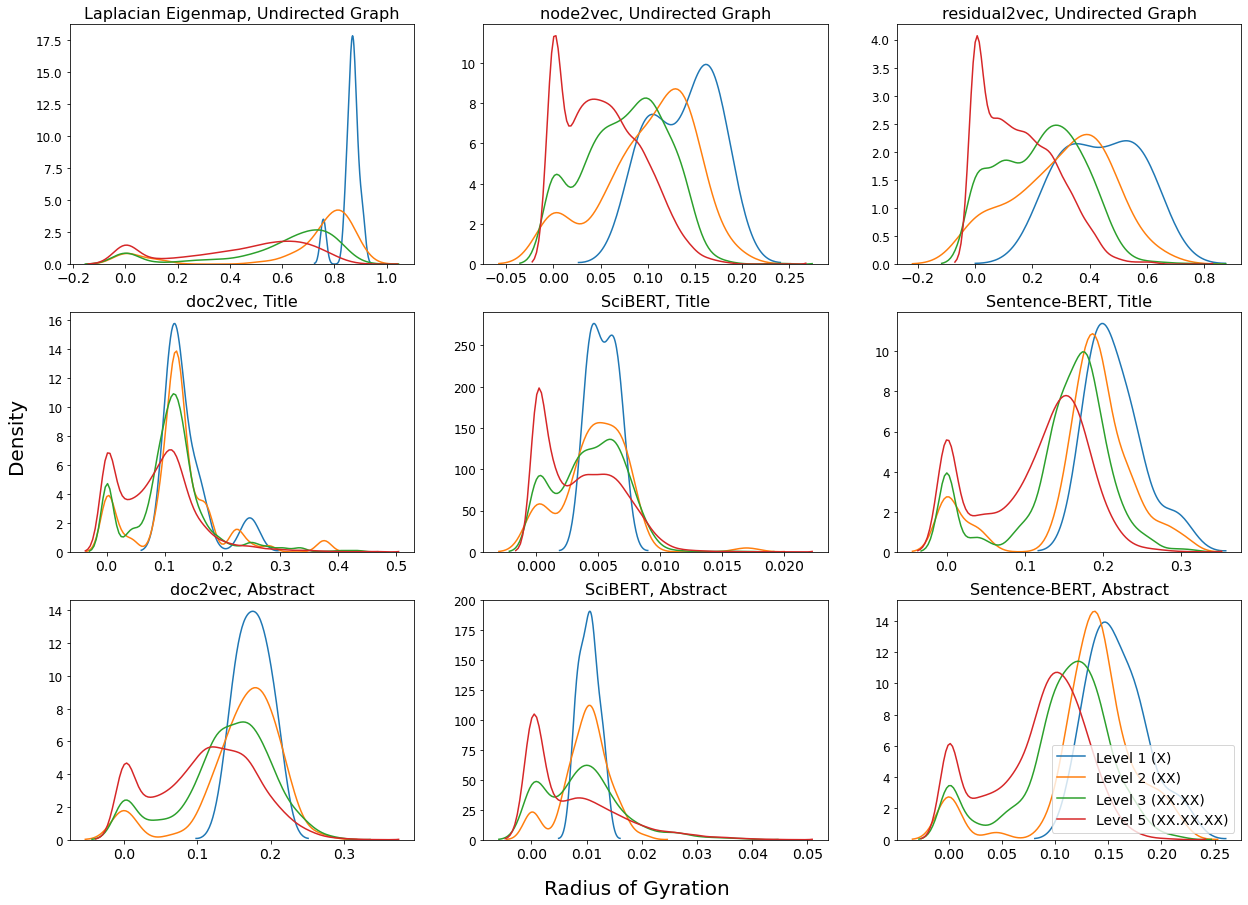

In [70]:
fig = plt.figure(figsize=(21,15))
fig.text(0.5, 0.08, 'Radius of Gyration', ha='center', va='center', fontsize=20)
fig.text(0.09, 0.5, 'Density', ha='center', va='center', rotation='vertical', fontsize=20)
for i in range(len(rogs)):
    pe = list(rogs.keys())[i]
    df = list(rogs.values())[i]
    PROPERTY = pe[0]
    EMBEDDING_METHOD = pe[1]
    
    try:
        st_prop = prop_stylized[PROPERTY]
    except KeyError:
        st_prop = PROPERTY
    try:
        st_emb = emb_stylized[EMBEDDING_METHOD]
    except KeyError:
        st_emb = EMBEDDING_METHOD
    
    ax = fig.add_subplot(3,3,i+1)
    
    # Plot ROG
    sns.kdeplot(df.loc[1, "ROG"], label="Level 1 (X)", ax=ax)
    sns.kdeplot(df.loc[2, "ROG"], label="Level 2 (XX)", ax=ax)
    sns.kdeplot(df.loc[3, "ROG"], label="Level 3 (XX.XX)", ax=ax)
    sns.kdeplot(df.loc[5, "ROG"], label="Level 5 (XX.XX.XX)", ax=ax)
    
    #ax.axis(xmin=0,xmax=2, ymin=0, ymax=5)
    ax.set_title("{}, {}".format(st_emb, st_prop))  #("{} {} Embedding Cosine Distance".format(st_prop, st_emb))
    ax.title.set_size(16)
    ax.tick_params(axis='both', which='major', labelsize=14)
    if i==len(EMB_METHOD)-1:
        ax.legend(fontsize=14, loc="lower right")
    else:
        ax.get_legend().remove()
    
    # Prettify
    ax.set_title("{}, {}".format(st_emb, st_prop))  #("{} {} Embedding Cosine Distance".format(st_prop, st_emb))
    ax.set(xlabel=None, ylabel=None)
    ax.title.set_size(16)
    ax.tick_params(axis='y', which='major', labelsize=12)
    ax.tick_params(axis='x', which='major', labelsize=14)
        
plt.subplots_adjust(wspace=0.2, hspace=0.2)

plt.savefig(
    "aps_all_2010_rog_dist.pdf",
    bbox_inches="tight",
)